# Scope of this workbook

Here, we want to actually model the whole thing for different datasets. 

In [108]:
# Imports
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

import datetime

from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor


#Settings
pd.set_option("display.max_rows", 70)
pd.set_option("display.max_columns", 101)

# Processed Dataset

In [109]:
full_df = pd.read_pickle('../data/finalized/full_df.pkl')

#full_df.describe()

In [110]:
full_df.head()

,ac_registration_x,Ac Type Code,sched_trans_time,flt_event_number,leg,block_delay,day_of_week,hour_of_day_dep,hour_of_day_arr,minute_of_day_dep,sched_groundtime_before,Crewchange_before,rows_to_drop_grounddelay
0,ECLBAX,321,0,1,New Jessica-East Carmen,-9.000,5,3,6,205,95.000,first flt of day,0
1,ECLBAX,321,60,2,East Carmen-South Nathaniel,-9.000,5,8,10,500,95.000,both,0
2,ECLBAX,321,75,3,South Nathaniel-East Carmen,-14.000,5,11,14,710,75.000,no change,0
3,ECLBAX,321,70,4,East Carmen-Joneshaven,-11.000,5,15,17,935,80.000,both,0
4,ECLBAX,321,50,5,Joneshaven-East Carmen,-10.000,5,17,19,1070,50.000,no change,1


## Encoding & Train/Test split

In [111]:
# Creating dummy variables for all categorical variables
# Note: Onehotencoder is the better solution, however for simplicity let's use pandas for the moment

# Get object columns
full_df_objectcolumns = full_df.select_dtypes(include = ['object', 'category'])
varlist = full_df_objectcolumns.columns.values.tolist()

# get dummies
full_df_encoded = pd.get_dummies(full_df, columns = varlist, drop_first = True)

full_df_encoded.shape

(8422, 329)

In [112]:
# We split the forecast in two different forecasts - one for ground delay and one for block delay
# Note: this is coming from the previous approach where I tried to separate in between ground delay and block delay. block delay is now the overal delay at landing. 

# dropping the ground delay filter row
full_df_encoded_blockdelay = full_df_encoded.drop(['rows_to_drop_grounddelay'], axis = 1)
X_train_blockdelay_encoded, X_test_blockdelay_encoded, y_train_blockdelay_encoded, y_test_blockdelay_encoded = train_test_split(
    full_df_encoded_blockdelay.drop(['block_delay'], axis = 1), full_df_encoded_blockdelay['block_delay'], test_size=0.33)#, random_state=42)

# Filtering out rows which are skewing ground delay prediction
#full_df_encoded_grounddelay = full_df_encoded[full_df_encoded['rows_to_drop_grounddelay'] == 0]

#X_train_grounddelay_encoded, X_test_grounddelay_encoded, y_train_grounddelay_encoded, y_test_grounddelay_encoded = train_test_split(
#    full_df_encoded_grounddelay.drop(['ground_delay'], axis = 1), full_df_encoded_grounddelay['ground_delay'], test_size=0.33, random_state=42)



## Linear Regression (Base Model)


In [113]:
# Blocktime
lr_block = LinearRegression()

lr_block.fit(X_train_blockdelay_encoded, y_train_blockdelay_encoded)
lr_block.predict(X_test_blockdelay_encoded)

# Groundtime
#lr_ground = LinearRegression()

#lr_ground.fit(X_train_grounddelay_encoded, y_train_grounddelay_encoded)
#lr_ground.predict(X_test_grounddelay_encoded)

array([-5.06467628, -6.53974152, -4.91291809, ..., -3.10481262,
       -2.30384254, -4.37128258])

In [114]:
# Blocktime
r2_blockdelay = lr_block.score(X_test_blockdelay_encoded, y_test_blockdelay_encoded)
rmse_blockdelay = np.sqrt(mean_squared_error(y_test_blockdelay_encoded, lr_block.predict(X_test_blockdelay_encoded)))
print("The r^2 for Block delay is " + str(round(r2_blockdelay,4)))
print("The RMSE for Block delay is " + str(round(rmse_blockdelay,2)) + " minutes.")
print("\n")

# Groundtime
#r2_grounddelay = lr_ground.score(X_test_grounddelay_encoded, y_test_grounddelay_encoded)
#rmse_grounddelay = np.sqrt(mean_squared_error(y_test_grounddelay_encoded, lr_ground.predict(X_test_grounddelay_encoded)))
#print("The r^2 for Ground delay is " + str(round(r2_grounddelay,4)))
#print("The RMSE for Ground delay is " + str(round(rmse_grounddelay,2)) + " minutes.")

The r^2 for Block delay is -4783733.9971
The RMSE for Block delay is 15216.2 minutes.




# Baseline Model (Dummy)

In [115]:
dummy = DummyRegressor()
dummy.fit(X_train_blockdelay_encoded, y_train_blockdelay_encoded)
dummy.predict(X_test_blockdelay_encoded)

array([-4.99060617, -4.99060617, -4.99060617, ..., -4.99060617,
       -4.99060617, -4.99060617])

In [116]:

r2_blockdelay = dummy.score(X_test_blockdelay_encoded, y_test_blockdelay_encoded)
rmse_blockdelay = np.sqrt(mean_squared_error(y_test_blockdelay_encoded, dummy.predict(X_test_blockdelay_encoded)))
print("The RMSE for Block delay is " + str(round(rmse_blockdelay,2)) + " minutes.")

The RMSE for Block delay is 6.96 minutes.


## Setup of Modelling

In [117]:
# Imports 
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV


In [118]:
%%time
# Initialize estimators

#reg1 = LinearRegression()
reg2 = Ridge()
reg3 = Lasso()
reg4 = GradientBoostingRegressor()
reg5 = ElasticNet()

# Initialize hyperparameters for each dictionary
#param1 = {}

param2 = {}
param2['regressor__alpha'] = [x for x in np.linspace(0,10,num = 51)]
param2['regressor'] = [reg2]

param3 = {}
param3['regressor__alpha'] = [x for x in np.linspace(0,10,num = 51)]
param3['regressor'] = [reg3]

param4 = {}
param4['regressor__n_estimators'] = [55,56,57,58] #[10,50,100,150,250]#[10,50,100,150,200,250]
param4['regressor__max_depth'] = [12,13,14]#,18,20]#,18]#,22] #[2,3,6,8,10,12,18] #[2,3,4,6,8,10,12,15,18]
param4['regressor__max_leaf_nodes'] = [28,29,30]#[6,8,12,15,19,25]#,18] #[6,8,12,None] #[6,8,12,15,19,25,None]
param4['regressor'] = [reg4]

param5 = {}
param5['regressor__alpha'] = [x for x in np.linspace(0.001,10,num = 10)]
param5['regressor__l1_ratio'] = [x for x in np.linspace(0,1,num = 10)]
param5['regressor__max_iter'] = [2000]
param5['regressor'] = [reg5]


# Create Pipeline
pipeline = Pipeline([('regressor', reg2)])
params = [param2, param3, param5, param4]

# Train grid search model
gs_block = GridSearchCV(pipeline, params, cv=5, n_jobs=-1, scoring='neg_root_mean_squared_error', verbose=1).fit(X_train_blockdelay_encoded,y_train_blockdelay_encoded)
#gs_ground = GridSearchCV(pipeline, params, cv=5, n_jobs=-1, scoring='neg_root_mean_squared_error', verbose=1).fit(X_train_grounddelay_encoded,y_train_grounddelay_encoded)

print(gs_block.best_estimator_, gs_block.best_params_)
#print(gs_ground.best_estimator_, gs_ground.best_params_)

#Evaluation
# Blocktime
r2_blockdelay = gs_block.best_estimator_.score(X_test_blockdelay_encoded, y_test_blockdelay_encoded)
rmse_blockdelay = np.sqrt(mean_squared_error(y_test_blockdelay_encoded, gs_block.best_estimator_.predict(X_test_blockdelay_encoded)))
print("The r^2 for Block delay is " + str(round(r2_blockdelay,4)))
print("The RMSE for Block delay is " + str(round(rmse_blockdelay,2)) + " minutes.")
print("\n")

# Groundtime
#r2_grounddelay = gs_ground.best_estimator_.score(X_test_grounddelay_encoded, y_test_grounddelay_encoded)
#rmse_grounddelay = np.sqrt(mean_squared_error(y_test_grounddelay_encoded, gs_ground.best_estimator_.predict(X_test_grounddelay_encoded)))
#print("The r^2 for Ground delay is " + str(round(r2_grounddelay,4)))
#print("The RMSE for Ground delay is " + str(round(rmse_grounddelay,2)) + " minutes.")





Fitting 5 folds for each of 238 candidates, totalling 1190 fits
Pipeline(steps=[('regressor',
                 GradientBoostingRegressor(max_depth=13, max_leaf_nodes=29,
                                           n_estimators=58))]) {'regressor': GradientBoostingRegressor(max_depth=13, max_leaf_nodes=29, n_estimators=58), 'regressor__max_depth': 13, 'regressor__max_leaf_nodes': 29, 'regressor__n_estimators': 58}
The r^2 for Block delay is 0.2443
The RMSE for Block delay is 6.05 minutes.


CPU times: total: 8.95 s
Wall time: 3min 24s


In [100]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
results = pd.DataFrame(gs_block.cv_results_).sort_values(by='rank_test_score')

results.head(10)



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor,param_regressor__alpha,param_regressor__max_depth,param_regressor__max_leaf_nodes,param_regressor__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
119,5.894,0.187,0.012,0.000,"GradientBoostingRegressor(max_depth=13, max_le...",NaN,13,29,56,{'regressor': GradientBoostingRegressor(max_de...,-6.081,-5.884,-5.872,-6.062,-5.920,-5.964,0.089,1
120,6.109,0.113,0.017,0.009,"GradientBoostingRegressor(max_depth=13, max_le...",NaN,13,29,57,{'regressor': GradientBoostingRegressor(max_de...,-6.078,-5.884,-5.875,-6.062,-5.920,-5.964,0.088,2
121,6.090,0.154,0.013,0.002,"GradientBoostingRegressor(max_depth=13, max_le...",NaN,13,29,58,{'regressor': GradientBoostingRegressor(max_de...,-6.083,-5.893,-5.874,-6.055,-5.917,-5.965,0.087,3
118,5.650,0.179,0.012,0.001,"GradientBoostingRegressor(max_depth=13, max_le...",NaN,13,29,55,{'regressor': GradientBoostingRegressor(max_de...,-6.078,-5.886,-5.871,-6.067,-5.921,-5.965,0.090,4
132,6.191,0.321,0.014,0.003,"GradientBoostingRegressor(max_depth=13, max_le...",NaN,14,29,57,{'regressor': GradientBoostingRegressor(max_de...,-6.086,-5.893,-5.876,-6.051,-5.942,-5.970,0.084,5
111,5.640,0.186,0.012,0.001,"GradientBoostingRegressor(max_depth=13, max_le...",NaN,12,30,56,{'regressor': GradientBoostingRegressor(max_de...,-6.077,-5.908,-5.871,-6.050,-5.941,-5.970,0.080,6
133,6.394,0.421,0.012,0.001,"GradientBoostingRegressor(max_depth=13, max_le...",NaN,14,29,58,{'regressor': GradientBoostingRegressor(max_de...,-6.091,-5.891,-5.873,-6.055,-5.939,-5.970,0.088,7
130,6.170,0.273,0.013,0.002,"GradientBoostingRegressor(max_depth=13, max_le...",NaN,14,29,55,{'regressor': GradientBoostingRegressor(max_de...,-6.087,-5.899,-5.877,-6.052,-5.942,-5.971,0.084,8
131,5.982,0.192,0.014,0.005,"GradientBoostingRegressor(max_depth=13, max_le...",NaN,14,29,56,{'regressor': GradientBoostingRegressor(max_de...,-6.087,-5.897,-5.875,-6.054,-5.946,-5.972,0.084,9
113,6.326,0.324,0.014,0.001,"GradientBoostingRegressor(max_depth=13, max_le...",NaN,12,30,58,{'regressor': GradientBoostingRegressor(max_de...,-6.087,-5.904,-5.872,-6.056,-5.941,-5.972,0.085,10


In [33]:
# Evaluation per flight event number

full_df.head()

RMSEs = []
for i in range(1,11):
    indices = X_test_blockdelay_encoded[X_test_blockdelay_encoded['flt_event_number']==i].index
    rmse_blockdelay_flt_event = np.sqrt(
        mean_squared_error(y_test_blockdelay_encoded.loc[indices], 
        gs_block.best_estimator_.predict(X_test_blockdelay_encoded.loc[indices]))
        )
    n = X_test_blockdelay_encoded.loc[indices].shape[0]
    print('RMSE for Landing Delay for flight ', i , ' is ', round(rmse_blockdelay_flt_event,2), ' minutes, using ', n, ' test observations')
    
    RMSEs.append(rmse_blockdelay_flt_event)


RMSE for Landing Delay for flight  1  is  5.99  minutes, using  527  test observations
RMSE for Landing Delay for flight  2  is  5.95  minutes, using  497  test observations
RMSE for Landing Delay for flight  3  is  5.93  minutes, using  486  test observations
RMSE for Landing Delay for flight  4  is  6.25  minutes, using  417  test observations
RMSE for Landing Delay for flight  5  is  5.97  minutes, using  342  test observations
RMSE for Landing Delay for flight  6  is  6.23  minutes, using  277  test observations
RMSE for Landing Delay for flight  7  is  6.59  minutes, using  139  test observations
RMSE for Landing Delay for flight  8  is  5.61  minutes, using  76  test observations
RMSE for Landing Delay for flight  9  is  5.25  minutes, using  11  test observations
RMSE for Landing Delay for flight  10  is  2.93  minutes, using  4  test observations


0.11675089728685617

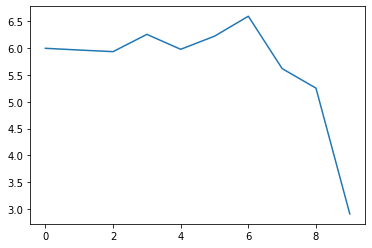

In [11]:
# Plotting the difference of RSMEs over flight events
plt.plot(RMSEs)

# Calculating the standard deviation over flight events per day
np.std(RMSEs[:5])

# Evaluation of Best Model

In [12]:
# Attention: The message of this is limited as we have not scaled the variables 

feature_importances = gs_block.best_estimator_.steps[0][1].feature_importances_

d = {'Features': X_train_blockdelay_encoded.columns, 'Importance': feature_importances}
eval = pd.DataFrame(data = d).sort_values(by = 'Importance', ascending = False)
eval.head(50)

,Features,Importance
78,Ac Type Code_DH4,0.154262
5,minute_of_day_dep,0.110421
79,Ac Type Code_DHX,0.048260
247,leg_Lake Lawrencechester-Lake Richardberg,0.037954
212,leg_East Latashaview-East Carmen,0.031727
4,hour_of_day_arr,0.027298
2,day_of_week,0.025931
6,sched_groundtime_before,0.025585
80,Ac Type Code_E95,0.019777
0,sched_trans_time,0.018581


In [ ]:
from sklearn.metrics import r2_score, mean_squared_error
# Create dataframe to save model evaluation parameters
eval = pd.DataFrame(columns= ['Group', 'Model', 'Parameters', 'R^2 test', 'RMSE test', 'R^2 train', 'RMSE train'])

# Create ridge regression models with best alpha values
rid_block = Ridge(alpha=2, fit_intercept=True)
rid_ground = Ridge(alpha=2, fit_intercept=True)

# Fit models to training data
rid_block.fit(X_train_blockdelay_encoded, y_train_blockdelay_encoded)
rid_ground.fit(X_train_grounddelay_encoded, y_train_grounddelay_encoded)

# Predict values for train and test data
rid_pred_block_train = rid_block.predict(X_train_blockdelay_encoded)
rid_pred_ground_train = rid_ground.predict(X_train_grounddelay_encoded)

rid_pred_block_test = rid_block.predict(X_test_blockdelay_encoded)
rid_pred_ground_test = rid_ground.predict(X_test_grounddelay_encoded)

# Save r^2 and RMSE for both models in dataframe for later comparison
eval = eval.append({
    'Group': 'Block',
    'Model': 'Ridge',
    'R^2 test': r2_score(y_test_blockdelay_encoded, rid_pred_block_test),
    'RMSE test': mean_squared_error(y_test_blockdelay_encoded, rid_pred_block_test, squared=False),
    'R^2 train': r2_score(y_train_blockdelay_encoded, rid_pred_block_train),
    'RMSE train': mean_squared_error(y_train_blockdelay_encoded, rid_pred_block_train, squared=False)
    }, ignore_index=True)
 
eval = eval.append({
    'Group': 'Ground',
    'Model': 'Ridge',
    'R^2 test': r2_score(y_test_grounddelay_encoded, rid_pred_ground_test),
    'RMSE test': mean_squared_error(y_test_grounddelay_encoded, rid_pred_ground_test, squared=False),
    'R^2 train': r2_score(y_train_grounddelay_encoded, rid_pred_ground_train),
    'RMSE train': mean_squared_error(y_train_grounddelay_encoded, rid_pred_ground_train, squared=False),
    }, ignore_index=True)

eval.round(decimals=3)

C:\Users\PC Paul\AppData\Local\Temp\ipykernel_18312\1589020009.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eval = eval.append({
C:\Users\PC Paul\AppData\Local\Temp\ipykernel_18312\1589020009.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eval = eval.append({


,Group,Model,Parameters,R^2 test,RMSE test,R^2 train,RMSE train
0,Block,Ridge,NaN,0.320295,5.734718,0.3692,5.378322
1,Ground,Ridge,NaN,0.672487,10.071233,0.718203,9.374951


## Gradient Boosted Tree

In [ ]:
# Gradientboosting as base classifier

# Blocktime
base_model_blockdelay = GradientBoostingRegressor()

base_model_blockdelay.fit(X_train_blockdelay_encoded, y_train_blockdelay_encoded)
base_model_blockdelay.predict(X_test_blockdelay_encoded)


# Groundtime

base_model_grounddelay = GradientBoostingRegressor()

base_model_grounddelay.fit(X_train_grounddelay_encoded, y_train_grounddelay_encoded)
base_model_grounddelay.predict(X_test_grounddelay_encoded)


array([44.41952744, 13.83831236, 25.63892846, ..., 29.71946156,
       -0.62027353,  9.36199806])

In [ ]:
# Blocktime
r2_blockdelay = base_model_blockdelay.score(X_test_blockdelay_encoded, y_test_blockdelay_encoded)
rmse_blockdelay = np.sqrt(mean_squared_error(y_test_blockdelay_encoded, base_model_blockdelay.predict(X_test_blockdelay_encoded)))
print("The r^2 for Block delay is " + str(round(r2_blockdelay,4)))
print("The RMSE for Block delay is " + str(round(rmse_blockdelay,2)) + " minutes.")
print("\n")

# Groundtime
r2_grounddelay = base_model_grounddelay.score(X_test_grounddelay_encoded, y_test_grounddelay_encoded)
rmse_grounddelay = np.sqrt(mean_squared_error(y_test_grounddelay_encoded, base_model_grounddelay.predict(X_test_grounddelay_encoded)))
print("The r^2 for Ground delay is " + str(round(r2_grounddelay,4)))
print("The RMSE for Ground delay is " + str(round(rmse_grounddelay,2)) + " minutes.")

The r^2 for Block delay is 0.8795
The RMSE for Block delay is 6.55 minutes.


The r^2 for Ground delay is 0.902
The RMSE for Ground delay is 5.53 minutes.
